This was meant to be a quick test for the primitive variable equations with $e^{ikz}$ z-dependence. I've solved these equations as a linear eigenvalue solve and get something sensible, but here as an IVP I'm getting solutions that look wrong and imaginary kinetic energy. Equations are cut and paste from the LEV notebook (Goodman & Ji 2002 LEV with e^{ikz}) so I'm sure it's something wrong in the numerical set-up.

In [1]:
%matplotlib nbagg
import time
import h5py
import matplotlib.pylab as plt
import numpy as np
import dedalus.public as de
from dedalus.extras import flow_tools

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [3]:
nr = 256

r_in = 5. # cm
r_out = 3*r_in
h = 10. # cm

nu = 3.26e-3 # cm^2/s
eta = 2000 # cm^2/s
rho = 6 # g/cm^3
B0 = 3000 # G

In [4]:
d = r_out - r_in
eps = h/d
K = np.pi/h * np.sqrt(1+eps**2)
Omega_in = 314 # rad/s
Omega_out = 37.9 # rad/s
Re_in = Omega_in/(nu*K**2)
Re_out = Omega_out/(nu*K**2)
zeta_bar = 2*(r_out**2 * Omega_out - r_in**2 * Omega_in)/((r_out**2 - r_in**2)*np.sqrt(Omega_in*Omega_out))
print("Re_in = {}; Re_out = {}".format(Re_in,Re_out))
print("zeta bar = {}".format(zeta_bar))

Re_in = 487957.8476026697; Re_out = 58896.823006819046
zeta bar = 0.062104757527239964


In [5]:
r = de.Chebyshev('r',nr,interval=[r_in, r_out])
domain = de.Domain([r], grid_dtype=np.complex128)

In [6]:
#domain.grid(0)

In [7]:
r_g = r.grid()

In [8]:
B = (Omega_out - Omega_in)/(1/r_out**2 - 1/r_in**2)
A = Omega_in - B/r_in**2

Omega = A + B/r_g**2

In [9]:
variables = ['u','v','w','Br','Bphi','Bz','p','vr','wr','Bphi_r']
gmri = de.IVP(domain,variables)
gmri.parameters['nu'] = nu
gmri.parameters['eta'] = eta
gmri.parameters['rho'] = rho
gmri.parameters['u0'] = 1
gmri.parameters['u0r'] = 1
gmri.parameters['B0'] = B0
gmri.parameters['pi'] = np.pi
gmri.parameters['k'] = np.pi/h
gmri.parameters['A'] = A
gmri.parameters['B'] = B
gmri.substitutions['ru0'] = '(r*r*A + B)' # u0 = r Omega(r) = Ar + B/r
gmri.substitutions['rrdu0'] = '(A*r*r-B)' # du0/dr = A - B/r^2

In [10]:
"""
gmri.add_equation("r**2*dt(u) - nu*r**2*(-k**2*u + k*wr)  + r**2*dr(p)/rho - 2*ru0*v + r**2*B0*k*Br/(4*pi*rho) = 0")
gmri.add_equation("r**2*dt(v) - nu*(r**2*dr(vr) + r*vr - r**2*k**2*v - v) + ru0*u + u*rrdu0 + r**2*B0*k*Bphi/(4*pi*rho) = 0")
gmri.add_equation("r*dt(w) - nu*(r*dr(wr) + wr - r*k**2*w) + r*k*p/rho - r*B0*k*Bz/(4*pi*rho) = 0")
gmri.add_equation("r*dr(u) + u - r*k*w = 0")
gmri.add_equation("vr - dr(v) = 0")
gmri.add_equation("wr - dr(w) = 0")
gmri.add_equation("dt(Br) - eta*(-k**2*Br - k*dr(Bz)) - B0*k*u = 0")
gmri.add_equation("r**2*dt(Bphi) - eta*(r**2*dr(Bphi_r) - r**2*k**2*Bphi + r*Bphi_r - Bphi) - Br*rrdu0 + ru0*Br - r**2*B0*k*v = 0")
gmri.add_equation("r*dr(Br) + Br + r*k*Bz = 0")
gmri.add_equation("Bphi_r - dr(Bphi) = 0")

"""
gmri.add_equation("r**2*dt(u) - nu*r**2*(-k**2*u + 1j*k*wr)  + r**2*dr(p)/rho - 2*ru0*v - r**2*B0*1j*k*Br/(4*pi*rho) = 0")
gmri.add_equation("r**2*dt(v) - nu*(r**2*dr(vr) + r*vr - r**2*k**2*v - v) + ru0*u + u*rrdu0 - r**2*B0*1j*k*Bphi/(4*pi*rho) = 0")
gmri.add_equation("r*dt(w) - nu*(r*dr(wr) + wr - r*k**2*w) + r*k*p/rho - r*B0*1j*k*Bz/(4*pi*rho) = 0")
gmri.add_equation("r*dr(u) + u + r*1j*k*w = 0")
gmri.add_equation("vr - dr(v) = 0")
gmri.add_equation("wr - dr(w) = 0")
gmri.add_equation("dt(Br) - eta*(-k**2*Br - 1j*k*dr(Bz)) - B0*1j*k*u = 0")
gmri.add_equation("r**2*dt(Bphi) - eta*(r**2*dr(Bphi_r) - r**2*k**2*Bphi + r*Bphi_r - Bphi) - Br*rrdu0 + ru0*Br - r**2*B0*1j*k*v = 0")
gmri.add_equation("r*dr(Br) + Br + r*1j*k*Bz = 0")
gmri.add_equation("Bphi_r - dr(Bphi) = 0")


In [11]:
# boundary conditions
gmri.add_bc("left(u) = 0")
gmri.add_bc("left(v) = 0")
gmri.add_bc("left(w) = 0")
gmri.add_bc("right(u) = 0")
gmri.add_bc("right(v) = 0")
gmri.add_bc("right(w) = 0")
gmri.add_bc("left(Br) = 0")
gmri.add_bc("right(Br) = 0")
gmri.add_bc("left(dr(r*Bphi)) = 0")
gmri.add_bc("right(dr(r*Bphi)) = 0")

In [12]:
dt = max_dt = 1.
period = 2*np.pi/Omega_in

ts = de.timesteppers.RK443
IVP = gmri.build_solver(ts)
IVP.stop_sim_time = 2000.*period
IVP.stop_wall_time = np.inf
IVP.stop_iteration = 500#00000

2016-05-05 09:01:28,364 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s


In [13]:
print(period)

0.02001014429038085


In [14]:
phi = domain.new_field(name='phi')
phi_z = domain.new_field(name='phi_z')

In [15]:
p = IVP.state['p']
u = IVP.state['u']
v = IVP.state['v']
w = IVP.state['w']
vr = IVP.state['vr']
wr = IVP.state['wr']
Br = IVP.state['Br']
Bphi = IVP.state['Bphi']
Bz = IVP.state['Bz']
for f in [phi,p,u,v,w,vr,wr]:
    f.set_scales(domain.dealias, keep_data=False)

In [16]:
# incompressible perturbation, arbitrary vorticity
k = gmri.parameters['k']

phi['g'] = (1e-3 + 1j*1e-3)*np.random.randn(*v['g'].shape)*np.sin(np.pi*(r_g - r_in))
phi['c'][nr/3:] = 0
phi.differentiate(0,out=w)
w['g'] += phi['g']/r_g
#w['g'] *= np.sin(np.pi*(r_g - r_in))
w.differentiate(0,out=wr)
u['g'] = -1j*k*phi['g']#*np.sin(np.pi*(r_g - r_in))

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Double check that $\nabla \cdot \mathbf{u} = 0$ to machine precision

$\nabla \cdot \mathbf{u} = \frac{1}{r} \partial_r(r u_r) + \partial_z u_z$

In [17]:
divu0 = domain.new_field(name='divu0') #del.u = dr(u_r) + u/r + dz(u_z)

u.differentiate(0,out=divu0) #dr(u_r)
divu0['g'] += u['g']/r_g + 1j*k*w['g'] #dr(u_r) + u/r + dz(u_z)

<IPython.core.display.Javascript object>


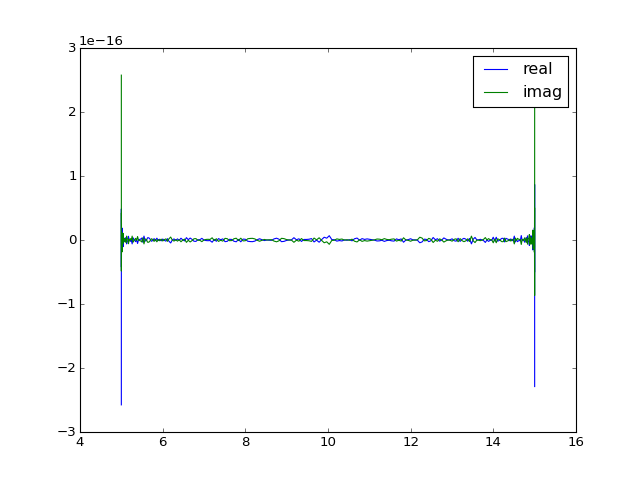

In [18]:
plt.figure()
plt.plot(r_g,divu0['g'].real)
plt.plot(r_g,divu0['g'].imag)
plt.legend(['real', 'imag'])

In [19]:
#CFL = flow_tools.CFL(IVP, initial_dt=1e-3, cadence=5, safety=0.3,
#                     max_change=1.5, min_change=0.5)
CFL = flow_tools.CFL(IVP, initial_dt=1e-3, cadence=5, safety=0.3,
                     max_change=1.5, min_change=0.5)
CFL.add_velocities(('u'))

In [20]:
# Integrated energy every 10 iterations
analysis1 = IVP.evaluator.add_file_handler("scalar_data", iter=10)
analysis1.add_task("integ(0.5 * (u*u + v*v + w*w))", name="total kinetic energy")
analysis1.add_task("integ(0.5 * (u*u + w*w))", name="meridional kinetic energy")
analysis1.add_task("integ((u*u)**0.5)", name='u_rms')
analysis1.add_task("integ((w*w)**0.5)", name='w_rms')

# Snapshots every half an inner rotation period
analysis2 = IVP.evaluator.add_file_handler('snapshots',sim_dt=0.5*period, max_size=2**30)
analysis2.add_system(IVP.state, layout='g')

In [21]:
dt = CFL.compute_dt()
# Main loop
start_time = time.time()

while IVP.ok:
    IVP.step(dt)
    if IVP.iteration % 10 == 0:
        logger.info('Iteration: %i, Inner Cylinder Rev: %e, Time: %e, dt: %e' %(IVP.iteration, IVP.sim_time/period,IVP.sim_time, dt))
    dt = CFL.compute_dt()


end_time = time.time()

# Print statistics
logger.info('Total time: %f sec' %(end_time-start_time))
logger.info('Iterations: %i' %IVP.iteration)

2016-05-05 09:01:31,173 __main__ 0/1 INFO :: Iteration: 10, Inner Cylinder Rev: 8.745564e-01, Time: 1.750000e-02, dt: 2.250000e-03
2016-05-05 09:01:33,861 __main__ 0/1 INFO :: Iteration: 20, Inner Cylinder Rev: 2.842308e+00, Time: 5.687500e-02, dt: 5.062500e-03
2016-05-05 09:01:36,198 __main__ 0/1 INFO :: Iteration: 30, Inner Cylinder Rev: 7.269750e+00, Time: 1.454687e-01, dt: 1.139063e-02
2016-05-05 09:01:38,463 __main__ 0/1 INFO :: Iteration: 40, Inner Cylinder Rev: 1.723149e+01, Time: 3.448047e-01, dt: 2.562891e-02
2016-05-05 09:01:40,884 __main__ 0/1 INFO :: Iteration: 50, Inner Cylinder Rev: 3.964542e+01, Time: 7.933105e-01, dt: 5.766504e-02
2016-05-05 09:01:43,291 __main__ 0/1 INFO :: Iteration: 60, Inner Cylinder Rev: 9.007675e+01, Time: 1.802449e+00, dt: 1.297463e-01
2016-05-05 09:01:45,730 __main__ 0/1 INFO :: Iteration: 70, Inner Cylinder Rev: 1.742366e+02, Time: 3.486499e+00, dt: 1.453017e-01
2016-05-05 09:01:48,056 __main__ 0/1 INFO :: Iteration: 80, Inner Cylinder Rev: 2.0

In [22]:
print("sec per step = {0:8.4f}".format((end_time - start_time)/IVP.iteration))
z_g = domain.grid(0)

sec per step =   0.2223


In [23]:
scale_factor = 2.7/np.abs(v['g']).max()
print("scaling by {}".format(scale_factor))

scaling by 0.12421682648580293


<IPython.core.display.Javascript object>


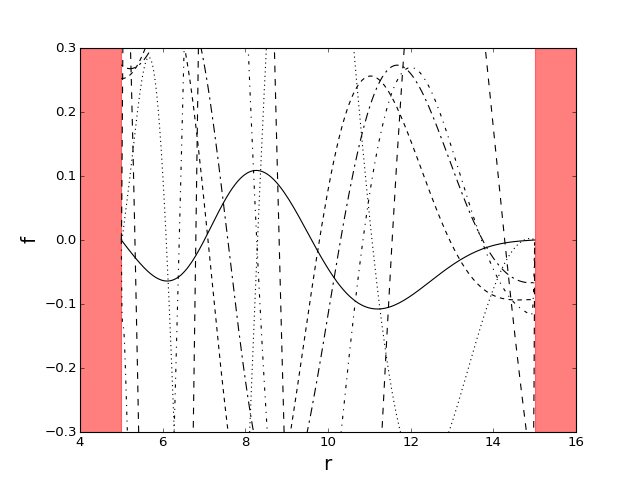

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.3, 0.3)

In [24]:
plt.figure()
plt.plot(z_g,scale_factor*v['g'],'k',ls='--')
plt.plot(z_g,scale_factor*u['g']/3.,'k',ls='dotted')
plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.')
plt.plot(z_g,scale_factor*Br['g']/np.sqrt(4*np.pi*rho),'k')
plt.plot(z_g,scale_factor*Bphi['g']/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(z_g,scale_factor*Bz['g']/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4, 5, alpha=0.5, color='red')
plt.axvspan(15, 16, alpha=0.5, color='red')

plt.xlim(4,16)
#plt.ylim(-0.4,0.4)
plt.ylim(-0.3, 0.3)

<IPython.core.display.Javascript object>


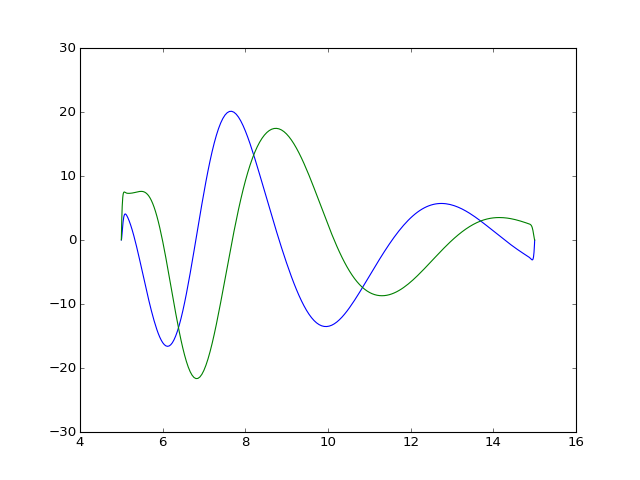

In [25]:
fig = plt.figure()
plt.plot(r_g, v['g'].real)
plt.plot(r_g, v['g'].imag)

In [26]:
def get_timeseries(data, field):
    data_1d = []
    time = data['scales/sim_time'][:]
    data_out = data['tasks/%s'%field][:,0]
    return time, data_out

In [27]:
data = h5py.File("scalar_data/scalar_data_s1/scalar_data_s1_p0.h5", "r")
t, ke = get_timeseries(data, 'total kinetic energy')
t, kem = get_timeseries(data, 'meridional kinetic energy')
t, urms = get_timeseries(data, 'u_rms')
t, wrms = get_timeseries(data, 'w_rms')

<IPython.core.display.Javascript object>


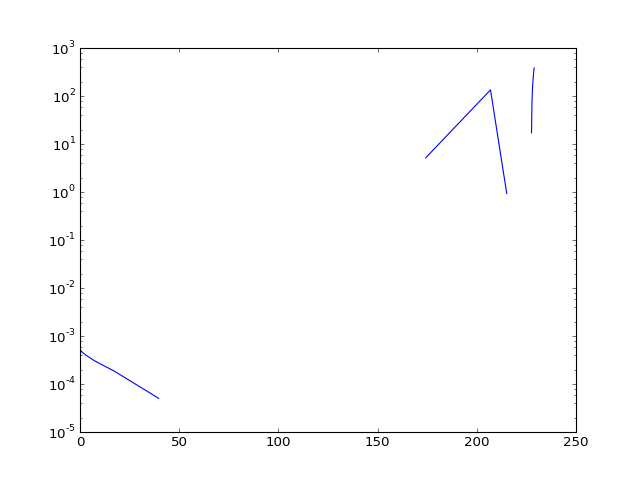

array([  0.00000000e+00 +5.29449540e-04j,
        -8.29869163e-08 +4.69090888e-04j,
        -8.84975983e-07 +4.02865496e-04j,
        -5.09336972e-06 +3.05295519e-04j,
        -2.12542607e-05 +1.85921846e-04j,
        -3.03442726e-05 +5.02649266e-05j,
        -3.05684378e-04 -4.11487908e-04j,
         8.73052768e-01 +5.14262445e+00j,
         4.13425310e+01 +1.34171658e+02j,
        -2.77585939e+02 +9.33661646e-01j,
        -2.93161951e+02 -1.56889409e+02j,
        -2.82707712e+02 -2.06218109e+02j,
        -2.70064059e+02 -2.43246340e+02j,
        -2.53490516e+02 -2.79314292e+02j,
        -2.33121817e+02 -3.14050760e+02j,
        -2.09122888e+02 -3.47106806e+02j,
        -1.81684203e+02 -3.78159987e+02j,
        -1.51020493e+02 -4.06913154e+02j,
        -1.17365457e+02 -4.33097873e+02j,
        -8.09670064e+01 -4.56475204e+02j,
        -4.20856776e+01 -4.76833943e+02j,
        -9.91984151e-01 -4.93990282e+02j,
         4.20360793e+01 -5.07787341e+02j,
         8.67153596e+01 -5.1809455

In [28]:
plt.figure()
plt.semilogy(t/period,ke.imag)
ke